# Best metric for rating movies

In [2]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
movies = pickle.load(open('../data/pickles/movies.p', 'rb'))
characters = pickle.load(open('../data/pickles/characters.p', 'rb'))
characters_movies = pd.merge(characters[['movie_wiki_id', 'actor_name', 'combined_birth', 'combined_gender']], movies[['wikipedia_id', 'title', 'combined_release_year', 'combined_runtime', 'combined_box_office', 'averageRating_imdb', 'numVotes_imdb']], left_on='movie_wiki_id', right_on='wikipedia_id', how='left')

## Box office revenue

In [4]:
print(f'There are {movies.combined_box_office.notna().sum()} movies with boxoffice revenue')

There are 12154 movies with boxoffice revenue


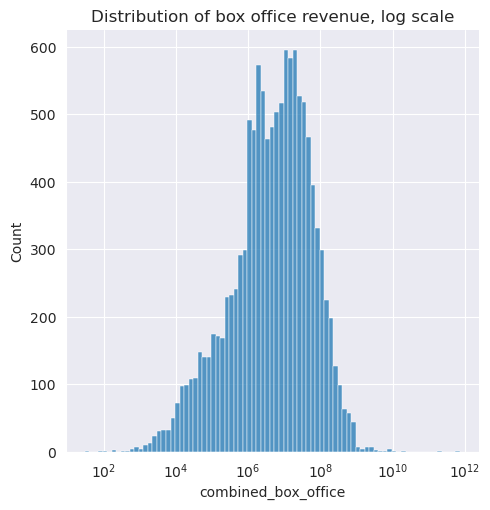

In [5]:
sns.displot(movies.combined_box_office, log_scale=True)
plt.title('Distribution of box office revenue, log scale')
plt.show()

## IMDB ratings

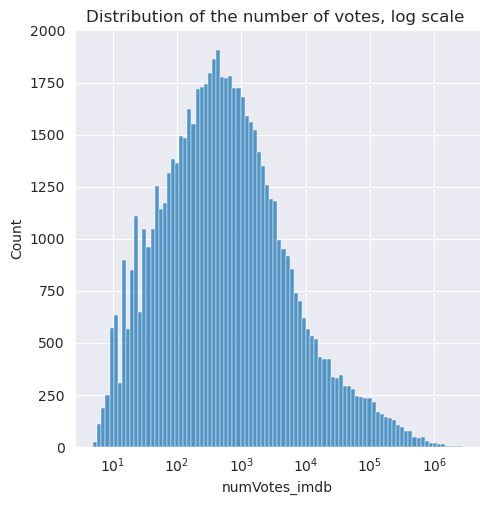

In [6]:
sns.displot(movies.numVotes_imdb, log_scale=True)
plt.title('Distribution of the number of votes, log scale ')
plt.show()

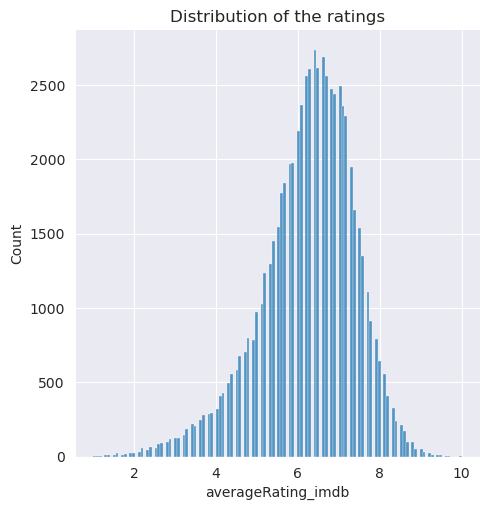

In [7]:
sns.displot(movies.averageRating_imdb)
plt.title("Distribution of the ratings")
plt.show()

### Movies with more than 10'000 votes

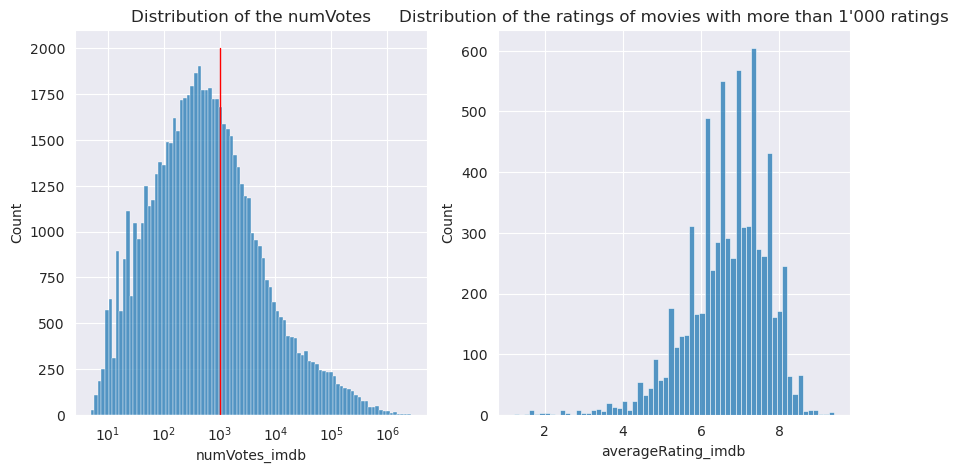

There are 25518 movies with more than 1'000 reviews.


In [8]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot([1e3,1e3], [0, 2000], linewidth=1, color='red')

sns.histplot(movies.numVotes_imdb, log_scale=True, ax=ax[0])
sns.histplot(movies.loc[movies.numVotes_imdb > 1e4].averageRating_imdb, ax=ax[1])

ax[0].title.set_text('Distribution of the numVotes')
ax[1].title.set_text("Distribution of the ratings of movies with more than 1\'000 ratings")
plt.show()
print(f'There are {(movies.numVotes_imdb > 1e3).sum()} movies with more than 1\'000 reviews.')

## Let's compare the numVotes distribution between the whole dataset and the movies with boxoffice

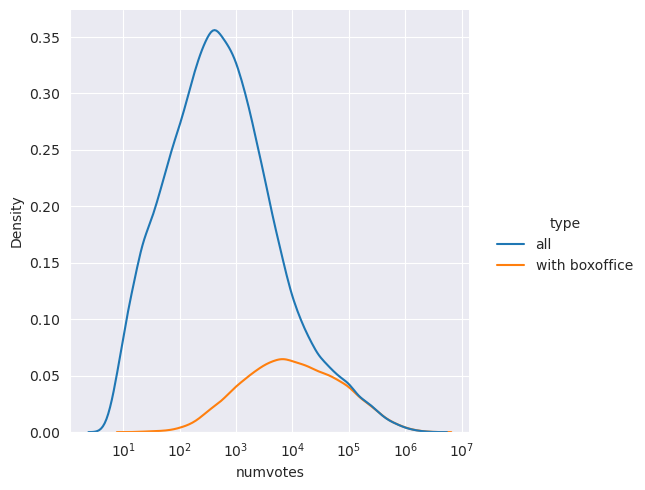

In [21]:
df = pd.DataFrame()
tempdf = pd.DataFrame()
tempdf['numvotes'] = movies.numVotes_imdb
tempdf['type'] = 'all'
df = pd.concat([df, tempdf])
tempdf = pd.DataFrame()
tempdf['numvotes'] = movies.loc[movies.combined_box_office.notna()].numVotes_imdb
tempdf['type'] = 'with boxoffice'
df = pd.concat([df, tempdf])
df = df.reset_index()
sns.displot(data=df, x='numvotes', hue='type', log_scale=True, kind='kde')
plt.show()

## Let's compare the distribution between male and female

In [10]:
female_with_boxoffice = characters_movies.loc[characters_movies.combined_gender=='female'].combined_box_office.notna().sum() / len(characters_movies.loc[characters_movies.combined_gender=='female'])
male_with_boxoffice = characters_movies.loc[characters_movies.combined_gender=='male'].combined_box_office.notna().sum() / len(characters_movies.loc[characters_movies.combined_gender=='male'])
print(f'Percentage of female actor with boxoffice: {100*female_with_boxoffice:.2f}%, male: {100*male_with_boxoffice:.2f}%')

Percentage of female actor with boxoffice: 30.67%, male: 30.93%


In [11]:
female_with_boxoffice = (characters_movies.loc[characters_movies.combined_gender=='female'].numVotes_imdb > 1e3).sum() / len(characters_movies.loc[characters_movies.combined_gender=='female'])
male_with_boxoffice = (characters_movies.loc[characters_movies.combined_gender=='male'].numVotes_imdb > 1e3).sum() / len(characters_movies.loc[characters_movies.combined_gender=='male'])
print(f'Percentage of female actor with more than 1000 ratings : {100*female_with_boxoffice:.2f}%, male: {100*male_with_boxoffice:.2f}%')

Percentage of female actor with more than 1000 ratings : 52.46%, male: 53.39%


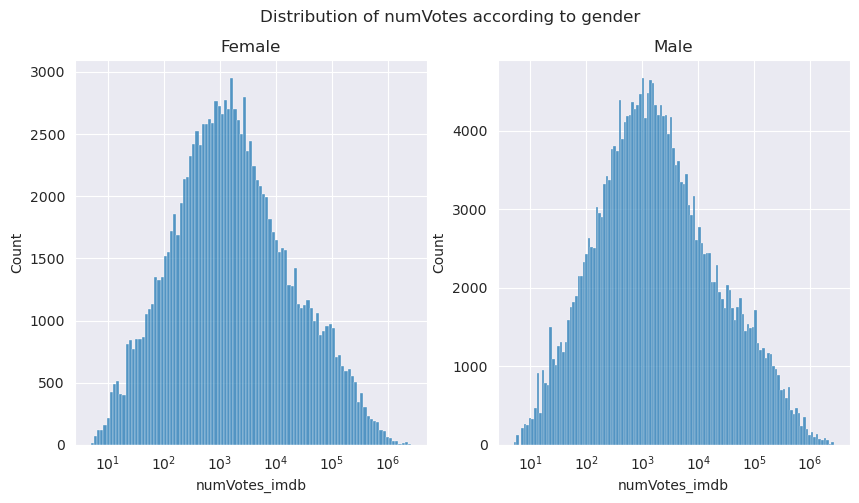

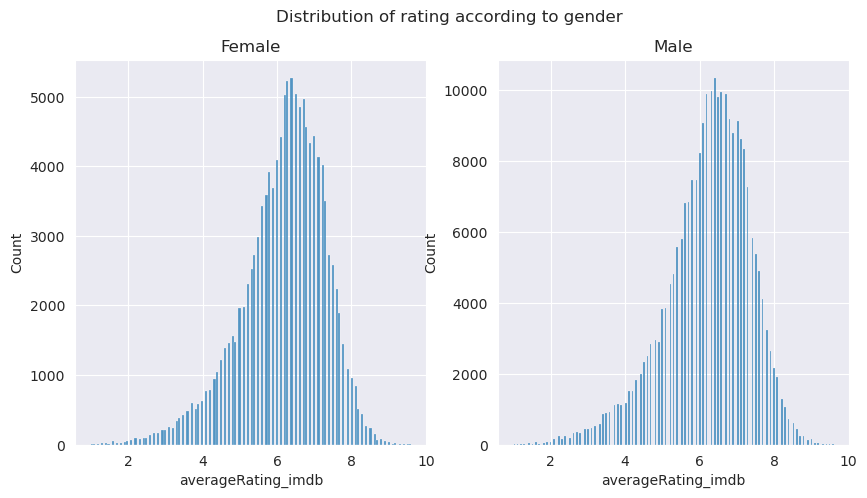

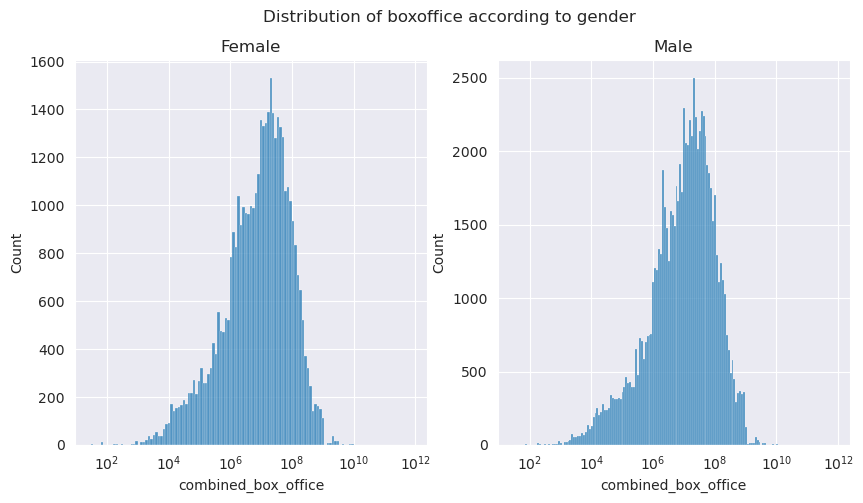

In [12]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.histplot(characters_movies.loc[characters_movies.combined_gender=='female'].numVotes_imdb, log_scale=True, ax=ax[0])
sns.histplot(characters_movies.loc[characters_movies.combined_gender=='male'].numVotes_imdb, log_scale=True, ax=ax[1])
ax[0].title.set_text('Female')
ax[1].title.set_text("Male")
plt.suptitle('Distribution of numVotes according to gender')
plt.show()

fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.histplot(characters_movies.loc[characters_movies.combined_gender=='female'].averageRating_imdb, log_scale=False, ax=ax[0])
sns.histplot(characters_movies.loc[characters_movies.combined_gender=='male'].averageRating_imdb, log_scale=False, ax=ax[1])
ax[0].title.set_text('Female')
ax[1].title.set_text("Male")
plt.suptitle('Distribution of rating according to gender')
plt.show()

fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.histplot(characters_movies.loc[characters_movies.combined_gender=='female'].combined_box_office, log_scale=True, ax=ax[0])
sns.histplot(characters_movies.loc[characters_movies.combined_gender=='male'].combined_box_office, log_scale=True, ax=ax[1])
ax[0].title.set_text('Female')
ax[1].title.set_text("Male")
plt.suptitle('Distribution of boxoffice according to gender')
plt.show()

# Very quick correlation check

In [13]:
import statsmodels.formula.api as smf
import numpy as np

In [14]:
characters_movies['age'] = characters_movies.combined_release_year - characters_movies.combined_birth

In [15]:
def run_model(df, formula, title):
    mod = smf.ols(formula=formula , data=df)
# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
    np.random.seed(2)
    res = mod.fit()
    print(res.summary())
    # feature names
    variables = res.params.index
    # quantifying uncertainty!
    # coefficients
    coefficients = res.params.values
    # p-values
    p_values = res.pvalues
    # stadard errors
    standard_errors = res.bse.values
    #confidence intervals
    res.conf_int()
    l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))
    #fancy plotting
    plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
                 linestyle = 'none',marker = 'o',markersize= 3,
                 markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

    plt.vlines(0,0, len(l1), linestyle = '--')

    plt.yticks(range(len(l2)),l2)
    plt.title(title)
    plt.show()
    print(f'R-squared value: {res.rsquared}')


## IMDB Ratings

                            OLS Regression Results                            
Dep. Variable:     averageRating_imdb   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     3487.
Date:                Sun, 04 Dec 2022   Prob (F-statistic):               0.00
Time:                        14:37:02   Log-Likelihood:            -1.0821e+05
No. Observations:               79545   AIC:                         2.164e+05
Df Residuals:                   79541   BIC:                         2.165e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

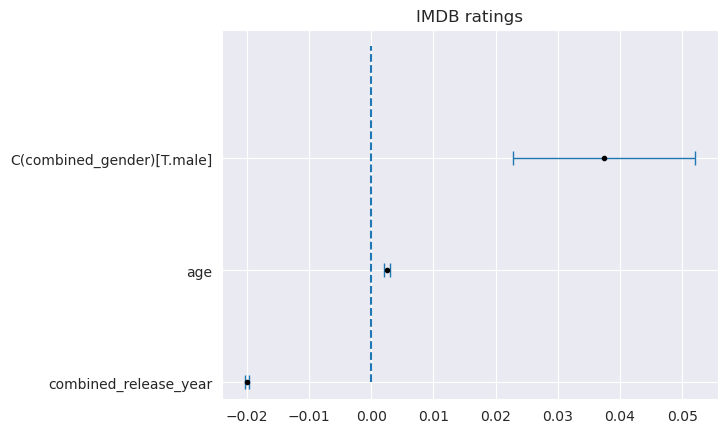

R-squared value: 0.11623377696662818


In [16]:
df = characters_movies.loc[(characters_movies.numVotes_imdb > 1e4) & ((characters_movies.combined_gender == 'female') | (characters_movies.combined_gender == 'male')) & (characters_movies.age > 0)]
run_model(df, 'averageRating_imdb ~ C(combined_gender) + (combined_release_year) + (age)', 'IMDB ratings')

## BoxOffice

/tmp/ipykernel_10424/385099111.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['combined_box_office'] = np.log(df.combined_box_office)


                             OLS Regression Results                            
Dep. Variable:     combined_box_office   R-squared:                       0.019
Model:                             OLS   Adj. R-squared:                  0.019
Method:                  Least Squares   F-statistic:                     700.1
Date:                 Sun, 04 Dec 2022   Prob (F-statistic):               0.00
Time:                         14:45:27   Log-Likelihood:            -2.5613e+05
No. Observations:               110712   AIC:                         5.123e+05
Df Residuals:                   110708   BIC:                         5.123e+05
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept 

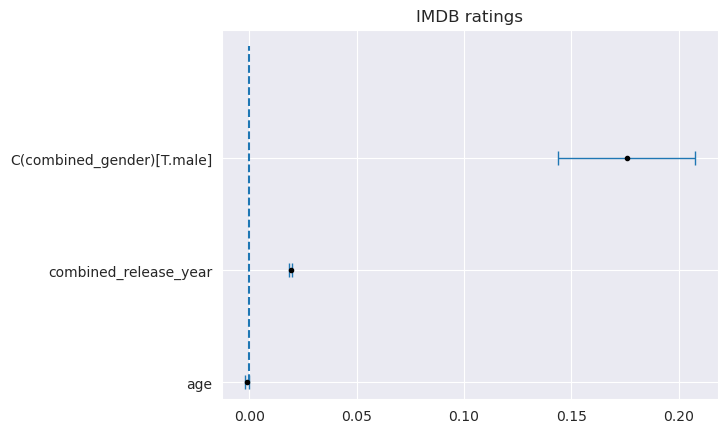

R-squared value: 0.018619248909280017


In [19]:
df = characters_movies.loc[(characters_movies.combined_box_office.notna()) & ((characters_movies.combined_gender == 'female') | (characters_movies.combined_gender == 'male')) & (characters_movies.age > 0)]
df['combined_box_office'] = np.log(df.combined_box_office)
run_model(df, 'combined_box_office ~ C(combined_gender) + (combined_release_year) + (age)', 'IMDB ratings')

                            OLS Regression Results                            
Dep. Variable:          numVotes_imdb   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     2427.
Date:                Sun, 04 Dec 2022   Prob (F-statistic):               0.00
Time:                        14:48:23   Log-Likelihood:            -3.8155e+06
No. Observations:              291326   AIC:                         7.631e+06
Df Residuals:                  291322   BIC:                         7.631e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

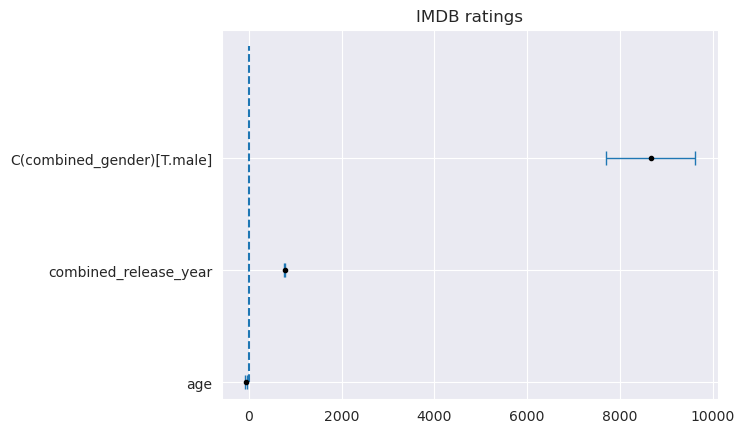

R-squared value: 0.02438403191430183


In [23]:
df = characters_movies.loc[(characters_movies.numVotes_imdb > 100) & ((characters_movies.combined_gender == 'female') | (characters_movies.combined_gender == 'male')) & (characters_movies.age > 0)]
run_model(df, 'numVotes_imdb ~ C(combined_gender) + (combined_release_year) + (age)', 'IMDB ratings')

In [36]:
print(movies.loc[(movies.numVotes_imdb > 1e5) & ((movies.averageRating_imdb < 5) | (movies.averageRating_imdb > 8.5))][['title', 'averageRating_imdb']].sort_values('averageRating_imdb'))

                                                   title  averageRating_imdb
9047                                          Epic Movie                 2.4
5247                                   Meet the Spartans                 2.8
19911                                           Catwoman                 3.4
24894                                     Batman & Robin                 3.7
19377                                 The Last Airbender                 4.0
2942                                            Movie 43                 4.3
79818                   Ghost Rider: Spirit of Vengeance                 4.3
39239                                       Home Alone 3                 4.5
31338                 AVPR: Aliens vs Predator - Requiem                 4.6
62829                                           New Moon                 4.7
43893                                        After Earth                 4.8
11575                                           Anaconda                 4.8

In [48]:
df = movies[['title', 'averageRating_imdb', 'numVotes_imdb', 'combined_box_office']].copy()
df['numVotes_imdb'] = np.log(df.numVotes_imdb)
df['combined_box_office'] = np.log(df.combined_box_office)
df['numVotes_imdb'] =(df.numVotes_imdb - df.numVotes_imdb.mean()) / df.numVotes_imdb.std()
df['combined_box_office'] =(df.combined_box_office - df.combined_box_office.mean()) / df.combined_box_office.std()
df['averageRating_imdb'] =(df.averageRating_imdb - df.averageRating_imdb.mean()) / df.averageRating_imdb.std()



In [49]:
df['metric'] = df.numVotes_imdb * np.abs(df.averageRating_imdb)

In [51]:
df.sort_values('metric', ascending=False).head(50)

,title,averageRating_imdb,numVotes_imdb,combined_box_office,metric
26366,The Shawshank Redemption,2.650255,3.734690,0.727960,9.897882
36402,The Godfather,2.563508,3.572760,1.557852,9.158800
38158,The Dark Knight,2.390014,3.729987,1.859599,8.914723
36295,Justin Bieber: Never Say Never,-4.029268,2.167110,1.210394,8.731866
80920,The Lord of the Rings: The Return of the King,2.390014,3.569991,1.998004,8.532330
7899,Disaster Movie,-3.769027,2.248341,0.807304,8.474059
66299,Pulp Fiction,2.303267,3.616566,1.243547,8.329917
25386,Schindler's List,2.390014,3.434384,1.198649,8.208227
60260,Inception,2.216520,3.676653,2.028329,8.149376
11063,The Godfather Part II,2.390014,3.405764,0.927427,8.139823
